# Deep Learning Project Walkthrough- Image Classification using CNN

---
***
<h3>Your Complete Guide on How to Make a Complete Deep Learning Project</h3>

Deep learning is a fancy word nowadays that you, as an aspiring Data Scientist might hear all the time. Whether it be the futuristic [Tesla Autopilot](http://www.tesla.com/autopilot) or your iOS or Android device's smart photo gallery that automatically segments your pictures using facial recognition and object detection, deep learning is everywhere. 

The sheer power that deep learning unlocks for you in terms of what you can achieve via it, that rapid advancements in the fields of AI due to deep learning; this never fails to amaze me.

The aim of this article here is to introduce you to the magic of Deep Learning. We will see how to train a Deep Learning model (that uses the CNN algorithm) capable of recognizing the scene in an image.

---
## Understanding the Problem Statement
---

For this project, we will be working on the [Intel Image Classification](https://www.kaggle.com/puneet6060/intel-image-classification) dataset. 


This is a multi-class classification problem where, given a picture, we want our model to classify it as one of the six possible scenes - buildings (0), forest (1), glacier (2), mountain (3), sea (4) or street (5).

As per the data source, each image is a 150 × 150 pixel, 3-channeled (RGB) image, with around 14k images in the training set and 3k images in the testing set.

---
## Importing Project Dependencies
---

First, we will import all the necessary Python PyData modules. 

*One thing to be noted is that we are implementing the model using PyTorch.*

In [62]:
import os 
import torch  
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score 
from PIL import Image

from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

torch.manual_seed(5)
np.random.seed(5)

%matplotlib inline

---
## Preparing the Dataset
---
Now comes the first tricky part. If you look at the dataset directory, you will observe that we don't have any CSV file or a directly labelled data to work with. Rather, the training and testing data directories are further divided into subdirectories for each possible outcome class. So, in order to be able to work with this data, we need to restructure the data into a format that we can work on; a format that we are used to working with, basically CSV files and pandas.DataFrame objects. Also, since we will be implementing our Deep Learning model using PyTorch, we need to convert the images into tensor objects.

From a programmer's problem solving perspective, let us break down these problems-

1. 
    * Formatting the unstructured dataset into structured CSV and dataframe objects 
    * Adding label to the data
2. 
    * Converting the images into tensor objects 
    * Converting the dataframe into a PyTorch dataset
    
3. Creating a method to view the images from their tensor form 

### Creating the CSV files and dataframe objects-

In [63]:
train_img_parent = "../input/intel-image-classification/seg_train/seg_train" # train directory address
test_img_parent = "../input/intel-image-classification/seg_test/seg_test" # test directory address

classLabels = {'buildings':0, 'mountain':1, 'street':2, 'forest':3, 'sea':4, 'glacier':5}

In [64]:
def csv_maker(parent_dir, class_label, csv_name):
    """Converts unstructured data stored in subdirectories into dataframe and csv file
    
    Args-
        parent_dir- String containing address of parent directory(test data or training data)
        class_label- Class label dictionary object
        csv_name- Name you want to give to your returned csv file (string) 
        
    Returns-
        dataframe- A pandas.DataFrame object
    """
    labelled_arr = np.array([]) # creates an empty array
    
    for subdir, label in class_label.items():
        img_dir = os.path.join(parent_dir, subdir) # gets the path of each subdirectory in the parent data directory
        files = np.array(os.listdir(img_dir)).reshape(-1,1) # gets the list of names of each image
        labels = np.array([label for i in range(files.shape[0])]).reshape(-1,1) #creates a label column for the images
        data = np.concatenate((files, labels), axis = 1) # concatenates file name and label arrays into a single array
        labelled_arr = np.append(labelled_arr, data)
    
    labelled_arr = labelled_arr.reshape(-1,2)
    
    np.random.seed(5)
    np.random.shuffle(labelled_arr) # shuffles the dataset
    
    dataframe = pd.DataFrame(labelled_arr)
    dataframe.columns = ['image', 'label']
    dataframe['label'] = dataframe['label'].astype('int') 
    
    dataframe.to_csv(csv_name, index = False) # creates the csv file for the dataframe
    
    return dataframe

In [65]:
train_df = csv_maker(train_img_parent, classLabels, csv_name = "train.csv")

test_df = csv_maker(test_img_parent, classLabels, csv_name = "test.csv")

train_csv = "./train.csv"
test_csv = "./test.csv"

---

Let us now have a look at our training and testing datasets.

---

In [66]:
print("\nTraining DF-\n")
print(train_df.head())
print("\nTesting DF-\n")
print(test_df.head())


Training DF-

       image  label
0  12336.jpg      3
1   5971.jpg      0
2  12589.jpg      4
3  10904.jpg      4
4  14826.jpg      0

Testing DF-

       image  label
0  23929.jpg      5
1  20142.jpg      5
2  21186.jpg      5
3  22201.jpg      3
4  20544.jpg      3


---
Now that we have created the dataframe objects and CSV files for the testing and training dataset, let's create the PyTorch dataset objects that will allow us to use the image data with our PyTorch model. 

---

In [67]:
# creating custom pytorch dataset

class ImageDataset(Dataset):
    def __init__(self, dataframe, data_dir, label_dict, transform = None):
        self.df = dataframe
        self.data_dir = data_dir
        self.label_dict = label_dict
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name, label = self.df.loc[idx]
        class_labels = list(self.label_dict.keys())
        img_path = self.data_dir + '/' + class_labels[label] + '/' + img_name
        img = img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label        

Now, one of the transformations we will be performing on our images is normalizing them. Normalization is a key step in Deep Learning. By restraining the range in which the values are spread into a small range, you can really speed up the training speed. 

---
\***NOTE**- Since the process of calculation of the normalization parameters (mean and standard deviation can be really a CPU-resource-intensive task, I'll just run the code once then comment it out while storing the values to speed up the process next time we run the notebook.)

In [68]:
# R_sum = 0
# G_sum = 0
# B_sum = 0

# for i in range(len(train_dataset)):
#     R_sum += train_dataset[i][0][0].sum()
#     G_sum += train_dataset[i][0][1].sum()
#     B_sum += train_dataset[i][0][2].sum()

# R_mean = R_sum / (256*256*len(train_dataset))
# G_mean = G_sum / (256*256*len(train_dataset))
# B_mean = B_sum / (256*256*len(train_dataset))

In [69]:
# mean = (R_mean, G_mean, B_mean)
mean = (0.4302, 0.4575, 0.4539)

In [70]:
# R2_sum = 0
# G2_sum = 0
# B2_sum = 0

# for i in range(len(train_dataset)):
#     R2_sum += ((train_dataset[i][0][0] - mean[0])**2).sum()
#     G2_sum += ((train_dataset[i][0][1] - mean[1])**2).sum()
#     B2_sum += ((train_dataset[i][0][2] - mean[2])**2).sum()

# R_std = (R2_sum / (256*256*len(train_dataset)))**0.5
# G_std = (G2_sum / (256*256*len(train_dataset)))**0.5
# B_std = (B2_sum / (256*256*len(train_dataset)))**0.5

In [71]:
# std = (R_std, G_std, B_std)
std = (0.2606, 0.2588, 0.2907)

In [72]:
# We will try different transforms on our training data and compare the results. For now, let us stick to the training transforms given below
transformTrain1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomErasing(),
])

transformTrain2 = None

# Transforms for test data
transformTest = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
])
    

In [73]:
# creating training dataset
train_dataset = ImageDataset(train_df, train_img_parent, classLabels, transform = transformTrain1)

# creating testing dataset
test_dataset = ImageDataset(test_df, test_img_parent, classLabels, transform = transformTest)

With this, we have successfully created both our training and testing datasets, and we are ready to work with them. 

But before we go on to the next step, let us first test our dataset and make sure it is working properly.

Total images in the dataset: 14034
tensor([[[-0.7479, -0.7780, -0.8232,  0.0045,  0.5312],
         [-0.7780, -0.7479, -0.7178, -0.2363,  0.0496],
         [-0.8232, -0.7178, -0.5673, -0.6125, -0.6877],
         [-0.6426, -0.4319, -0.0858, -0.1610, -0.2814],
         [-0.4319, -0.1159,  0.3807,  0.3506,  0.2001]],

        [[ 1.0204,  0.8991,  0.7021,  1.3840,  1.8235],
         [ 0.8082,  0.7628,  0.6870,  1.0507,  1.2628],
         [ 0.4900,  0.5658,  0.6567,  0.5355,  0.3839],
         [ 0.4142,  0.6112,  0.9446,  0.8385,  0.7021],
         [ 0.3839,  0.7325,  1.2628,  1.2325,  1.1113]],

        [[-0.7250, -0.8734, -1.1027, -0.5901, -0.3338],
         [-0.8869, -0.9409, -1.0353, -0.7655, -0.6576],
         [-1.1297, -1.0488, -0.9139, -1.0218, -1.1702],
         [-1.1162, -0.8734, -0.5092, -0.5631, -0.6576],
         [-1.0218, -0.6576, -0.0910, -0.0370, -0.1045]]])
Image label: forest


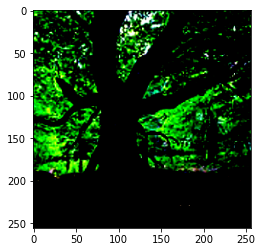

In [74]:
print("Total images in the dataset:", len(train_dataset))
img, label = train_dataset[0]
print(img[:,:5,:5]) # printing a small 3 x 5 x 5 slice of the 3 x 256 x 256 tensor
print("Image label:", list(classLabels.keys())[label])
plt.imshow(img.permute(1,2,0))


Now, the next challege. We need a method that allows us to feed data to our deep learning model for training as well as testing. Luckily, for this, we have the PyTorch's built-in DataLoader class. Let us create our dataloader objects.

### Defining Data Loaders

In [75]:
batch_size = 64
                                                                                
train_dl = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size, 
    shuffle = True, 
    num_workers = 2, 
    pin_memory = True)

test_dl = DataLoader(
    dataset = test_dataset, 
    batch_size = batch_size*2, 
    shuffle = False, 
    num_workers = 2, 
    pin_memory = True)

One thing to be noted is that we set **shuffle = False** for test data loader as we aren't training the model on the test data. We are just using it to make predictions, for which there's no need to shuffle the data.

In [76]:
test_dl

Now that we have our dataloaders created, let us create a method to visualize the images in a batch.

In [77]:
def batch_viewer(dataloader):
    """Shows the images in a batch returned by the PyTorch dataloader object.
    
    Args-
        dataloader- PyTorch dataloader object
    
    Returns-
        None
    """
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize = (16,16))
        ax.imshow(make_grid(images, nrow = 8).permute(1, 2, 0))
        break    

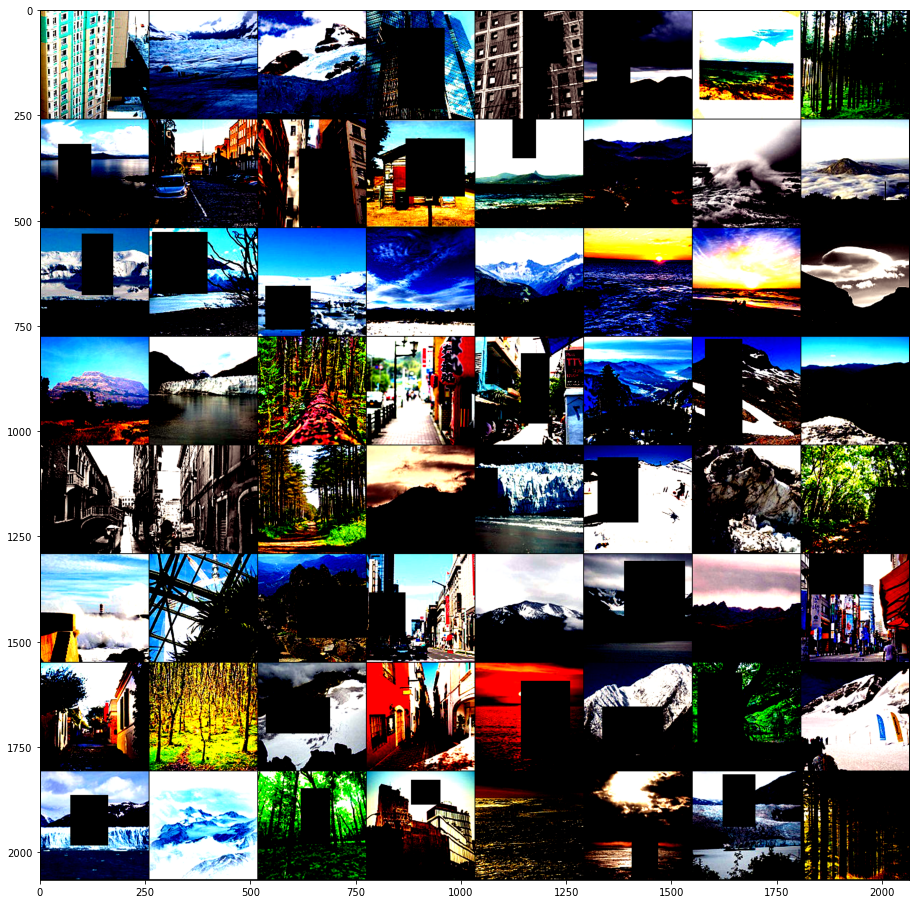

In [78]:
batch_viewer(train_dl)

---
## Model & Training
---

Now, let us move on to the next step. In this section, we will define our model class along with the loss function, scoring function and the various helper functions that will come handy while training and evaluating our model.

First, let us create a base class where we will define all the helper functions as well as our loss and accuracy functions. Then we will simply inherit the base class to another class where we will define our actual model.

This will allow us to keep our code clean and modular. Instead of redefining different model functions again and again from scratch, we can simply define a new model while our helper functions will remain the same.

In [84]:
def accuracy(output, labels):
    """Calculates the accuracy for the predicted output and the actual label values.
    
    Agrs-
        output- Output tensor generated by the model
        labels- Actual labels for the given batch of data
    
    Returns-
        accuracy- Accuracy percentage for the predictions
    """
    softmax = nn.Softmax()
    output = softmax(output) # converts output values to probability values for each class
    preds = torch.argmax(output, axis = 1) # sets class with max probability as prediction 
    accuracy = torch.sum(preds==labels).item() / len(labels) # accuracy = correct_prediction / total_predictions
    return accuracy

class SceneClassificationBase(nn.Module):
    def training_step(self, batch):
        """Calculates the cross entropy loss for a given batch of data.
        
        Args-
            batch- One batch of data as generated by the data loader
        
        Returns-
            batch_loss- Total cross entropy loss for the batch
        """
        images, labels = batch 
        output = self(images)                  # generates predictions for the batch of images
        batch_loss = F.cross_entropy(output, labels) # calculates loss for the predictions and actual labels
        return batch_loss
    
    def validation_step(self, batch):
        """Calculates total validation loss and validation accuracy for a given batch data during a validation step.
        
        Args-
            batch- One batch of data as generated by the data loader
            
        Returns-
            A dictionary object containing validation loss and validation accuracy for the given batch
        """
        images, labels = batch 
        output = self(images)                    # generate predictions for given batch
        batch_loss = F.cross_entropy(output, labels)   # calculates batch loss
        batch_acc = accuracy(output, labels)           # calculate batch accuracy
        return {'val_loss': batch_loss.detach(), 'val_acc': batch_acc}
        
    def validation_epoch_end(self, outputs):
        """Calculates mean validation loss and mean validation accuracy for a one validation epoch.
        
        Args-
            outputs- A list of dictionary objects containing validation accuracy and validation loss for each batch of data in one epoch
            
        Returns-
            A dictionary object containing validation loss and validation accuracy for the given batch
        """
        batch_losses = [batch_val_dict['val_loss'] for batch_val_dict in outputs] # creates a list of batch losses for all the batches in one validation epoch
        epoch_loss = torch.stack(batch_losses).mean()   # calculates mean validation loss for the epoch
        batch_accs = [batch_val_dict['val_acc'] for batch_val_dict in outputs]   # creates a list of batch accuracies for all the batches in one validation epoch 
        epoch_acc = torch.stack(batch_accs).mean()      # calculates mean validation accuracy for the epoch
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, 
            result['lrs'][-1], 
            result['train_loss'], 
            result['val_loss'], 
            result['val_acc']))

In [87]:
class Model_ResNet9(SceneClassificationBase):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(    # 3 x 256 x 256
            nn.Conv2d(3, 64, kernel_size = 3, padding = 1),    # 64 x 256 x 256
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
        )    
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),    # 128 x 256 x 256
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2),    # 128 x 128 x 128 
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1), # 128 x 128 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
            nn.Conv2d(128, 128, kernel_size = 3, padding = 1), # 128 x 128 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),    # 256 x 128 x 128
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2),   # 256 x 64 x 64 
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size = 3, padding = 1),    # 512 x 64 x 64
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, 2),    # 512 x 32 x 32 
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1), # 512 x 32 x 32
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
            nn.Conv2d(512, 512, kernel_size = 3, padding = 1), # 512 x 32 x 32
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),
        )
        self.classifier = nn.Sequential(nn.AvgPool2d(2, 2), # 512 x 16 x 16
                                        nn.Flatten(), 
                                        nn.Linear(512 * 16 * 16, 6),
        )
        
    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.res1(output) + output
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.res2(output) + output
        output = self.classifier(output)
        return output
        

Now that we have defined our model, let us create a model object and test if everything is working properly.

In [88]:
model_ResNet9 = SceneClassificationModel_ResNet9()
model_ResNet9

SceneClassificationModel_ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (conv3): Sequential(
    